# Krill Growth Potential (KGP) Data Processing from CESM2 Hindcast
- Process data for Southern Ocean total KGP in growing season
- Notebook by Zephyr Sylvester (CU Boulder), Alice DuVivier (NCAR), Kristen Krumhardt (NCAR)
- Note: this notebook needs to load the utils.py file
- June 2024

## Steps for calculating KGP

$KGP = length + CHL_{sfc} + SST$

We calculate Antarctic krill (Euphausia superba) growth potential using an empirical relationship derived from surface quantities. The method follows Atkinson et al. 2006 (https://www.doi.org/10.4319/lo.2006.51.2.0973). Specific equations for each step are provided in the "Calculate your metric" section.

1) Calculate total surface chlorophyll from all phytoplankton types

2) Calculate individual terms
- length term
- chlorophyll term
- SST term

3) Sum all terms to get KGP


In [1]:
import utils
import xarray as xr
import pandas as pd
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

## Spin up DASK cluster

In [2]:
import dask
from distributed import Client
from dask.distributed import wait
from ncar_jobqueue import NCARCluster

In [3]:
# Create our NCAR Cluster - which uses PBSCluster under the hood
cluster = NCARCluster(walltime='2:00:00', cores=1, processes=1, memory='100 GB', 
                      resource_spec='select=1:ncpus=1:mem=100GB',interface='ext')

# Spin up 32 workers
cluster.scale(32)

# Assign the cluster to our Client
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/41437/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/41437/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.105:44253,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/41437/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Read in Hindcast data

In [5]:
## Enter variable of interest
var_in_1 = 'TEMP'
var_in_2 = 'diatChl'
var_in_3 = 'spChl'
var_in_4 = 'diazChl'

## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [6]:
dir_in = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1/'

file_in = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch.pop.h.'+var_in_1+'.195801-202112.nc'
ds_1 = xr.open_mfdataset(dir_in+file_in,decode_times=False)
file_in = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch.pop.h.'+var_in_2+'.195801-202112.nc'
ds_2 = xr.open_mfdataset(dir_in+file_in,decode_times=False)
file_in = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch.pop.h.'+var_in_3+'.195801-202112.nc'
ds_3 = xr.open_mfdataset(dir_in+file_in,decode_times=False)
file_in = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch.pop.h.'+var_in_4+'.195801-202112.nc'
ds_4 = xr.open_mfdataset(dir_in+file_in,decode_times=False)

In [7]:
# preprocess data before calculations
print('getting top level (500cm) temperature')
temp = ds_1.TEMP
ds_1['TEMP'] = temp.isel(z_t=0)
ds_1['TEMP'].attrs['long_name'] = 'ocean temperature, surface (500cm)'

print('getting top level (500cm) diatom chlorophyll')
temp = ds_2.diatChl
ds_2['diatChl'] = temp.isel(z_t_150m=0)
ds_2['diatChl'].attrs['long_name'] = 'diatom chlorophyll, surface (500cm)'

print('getting top level (500cm) small phytoplankton chlorophyll')
temp = ds_3.spChl
ds_3['spChl'] = temp.isel(z_t_150m=0)
ds_3['spChl'].attrs['long_name'] = 'small phytoplankton chlorophyll, surface (500cm)'

print('getting top level (500cm) diazatroph chlorophyll')
temp = ds_4.diazChl
ds_4['diazChl'] = temp.isel(z_t_150m=0)
ds_4['diazChl'].attrs['long_name'] = 'diazatroph chlorophyll, surface (500cm)'

getting top level (500cm) temperature
getting top level (500cm) diatom chlorophyll
getting top level (500cm) small phytoplankton chlorophyll
getting top level (500cm) diazatroph chlorophyll


In [8]:
# combine into a single dataset
ds = ds_1
ds['diatChl'] = ds_2['diatChl']
ds['spChl']   = ds_3['spChl']
ds['diazChl'] = ds_4['diazChl']

In [9]:
# keep only some variables
keep_vars=['z_t','time_bound','z_t_150m','KMT','TLAT','TLONG','time','TEMP','diatChl','spChl','diazChl']
ds = ds.drop([v for v in ds.variables if v not in keep_vars])

In [10]:
# crop to southern ocean only
#ds = ds.isel(nlat=slice(0,36))
ds = ds.where(((ds['TLAT'] <= lat_max) & (ds['TLAT'] >= lat_min)), drop=True)

In [11]:
# check time array
ds.time

<xarray.DataArray 'time' (time: 768)>
array([714701., 714729., 714760., ..., 737969., 737999., 738030.])
Coordinates:
  * time     (time) float64 7.147e+05 7.147e+05 7.148e+05 ... 7.38e+05 7.38e+05
Attributes:
    long_name:     time
    units:         days since 0000-01-01 00:00:00
    bounds:        time_bound
    calendar:      noleap
    cell_methods:  time: mean

In [12]:
# to make useable time coordinate, create arrays for yyyy-mm-dd (NO LEAP!)
# We know it's monthly data for 1958.01-2021.12, not including leap days.

# create full range of dates at daily frequency
dates = pd.date_range(start='1/1/1958', end='12/31/2021', freq='M')
# check that the # times matches above
print(dates.shape)

(768,)


In [13]:
# assign the new time array
ds['time'] = dates

## Compute your metric!

### Calculate Surface Chlorophyll

```ds['Chl_surf'] = (ds.diatChl + ds.spChl + ds.diazChl)```

In [14]:
%%time
# Compute Surface Chl
ds['Chl_surf'] = (ds.diatChl + ds.spChl + ds.diazChl)
ds.Chl_surf.attrs = ds.diatChl.attrs
ds.Chl_surf.attrs['long_name'] = 'Surface chlorophyll'

CPU times: user 5.41 ms, sys: 452 µs, total: 5.86 ms
Wall time: 9.15 ms


### Calculate Individual terms

In [15]:
%%time

# specify constant parameters (from Atkinson et. al 2006)
a = -0.066
b = 0.002
c = -0.000061
d = 0.385
e = 0.328
f = 0.0078
g = -0.0101

# specify the krill length in mm (use 40 as default)
length = 40.

# compute terms and sum
length_term = (a + (b * length) + (c * length**2))
chl_term = (d * (ds.Chl_surf / (e + ds.Chl_surf)))
sst_term = ((f * ds.TEMP) + (g * ds.TEMP**2))

CPU times: user 8.08 ms, sys: 0 ns, total: 8.08 ms
Wall time: 8.13 ms


### Calculate KGP

In [16]:
varname = 'KGP'

In [17]:
%%time
# Compute KGP
# sum terms
kgp = length_term + chl_term + sst_term
# mask based on SST range
kgp = kgp.where((-1. <= ds.TEMP) & (ds.TEMP <= 5.)).fillna(0.).where(ds.KMT > 0).compute()

CPU times: user 2.45 s, sys: 105 ms, total: 2.55 s
Wall time: 1min 34s


In [18]:
# add this to the dataset
ds[varname] = kgp
ds[varname].attrs['long_name'] = 'Krill daily growth rate'
ds[varname].attrs['units'] = 'mm/day'

# Compute Seasonal Integrals
* Growing season = ONDJFM 
* Early Season = OND
* Late Season = JFM


In [19]:
#starting with Jan, list of days in each month
days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

In [20]:
yy_st = 1958
yy_ed = 2021

In [21]:
# Dataset will become shorter because of the Jan.1 boundary for some seasons
# for 1958-2021, 63 years long. Last year will be 2020
years = np.arange(int(yy_st),int(yy_ed),1)

tlen = 63 #annual timesteps 
xlen = len(ds.nlon)
ylen = len(ds.nlat)
print(tlen,xlen,ylen)

63 320 36


In [22]:
# set data metric for calculations
data_metric = kgp

### Compute Growing Season (ONDJFM)

In [23]:
%%time

ds_Oct_Mar_int = xr.Dataset()

Oct_Mar_int = np.zeros([tlen,ylen,xlen])

for year in np.arange(0,tlen,1):

    #get october for this year
    st_mon = year*12 + 9

    #sum over oct to following year march
    i=0
    for month in [10,11,12,1,2,3]:

        if(month == 10):
            summing = data_metric.isel(time=st_mon) * days_per_month[month-1]
        else:
            summing = summing + data_metric.isel(time=st_mon+i) * days_per_month[month-1]

        i = i + 1

    Oct_Mar_int[year,:,:] = summing

# convert to xarray
Oct_Mar_int = xr.DataArray(Oct_Mar_int,dims=('time','nlat','nlon'))

ds_Oct_Mar_int[varname] = Oct_Mar_int
ds_Oct_Mar_int[varname].attrs['units'] = 'mol/m2/year'
ds_Oct_Mar_int['time'] = years
ds_Oct_Mar_int

CPU times: user 477 ms, sys: 20.2 ms, total: 497 ms
Wall time: 1.12 s


<xarray.Dataset>
Dimensions:  (time: 63, nlat: 36, nlon: 320)
Coordinates:
  * time     (time) int64 1958 1959 1960 1961 1962 ... 2016 2017 2018 2019 2020
Dimensions without coordinates: nlat, nlon
Data variables:
    KGP      (time, nlat, nlon) float64 nan nan nan nan ... 20.36 20.41 20.45

### Compute Early Season (OND)

In [24]:
%%time

ds_OND_int = xr.Dataset()

OND_int = np.zeros([tlen,ylen,xlen])

for year in np.arange(0,tlen,1):

    #get october for this year
    st_mon = year*12 + 9

    #sum over oct to december
    i=0
    for month in [10,11,12]:

        if(month == 10):
            summing = data_metric.isel(time=st_mon) * days_per_month[month-1]
        else:
            summing = summing + data_metric.isel(time=st_mon+i) * days_per_month[month-1]

        i = i + 1

    OND_int[year,:,:] = summing

# convert to xarray
OND_int = xr.DataArray(OND_int,dims=('time','nlat','nlon'))

ds_OND_int[varname] = OND_int
ds_OND_int[varname].attrs['units'] = 'mol/m2/year'
ds_OND_int['time'] = years
ds_OND_int

CPU times: user 209 ms, sys: 9.15 ms, total: 218 ms
Wall time: 448 ms


<xarray.Dataset>
Dimensions:  (time: 63, nlat: 36, nlon: 320)
Coordinates:
  * time     (time) int64 1958 1959 1960 1961 1962 ... 2016 2017 2018 2019 2020
Dimensions without coordinates: nlat, nlon
Data variables:
    KGP      (time, nlat, nlon) float64 nan nan nan nan ... 14.85 14.79 14.73

### Compute Late Season (JFM)

In [25]:
%%time

ds_JFM_int = xr.Dataset()

JFM_int = np.zeros([tlen,ylen,xlen])

for year in np.arange(0,tlen,1):

    #get january for this year
    st_mon = year*12 + 0

    #sum over january to march
    i=0
    for month in [1,2,3]:

        if(month == 10):
            summing = data_metric.isel(time=st_mon) * days_per_month[month-1]
        else:
            summing = summing + data_metric.isel(time=st_mon+i) * days_per_month[month-1]

        i = i + 1

    JFM_int[year,:,:] = summing

# convert to xarray
JFM_int = xr.DataArray(JFM_int,dims=('time','nlat','nlon'))

ds_JFM_int[varname] = JFM_int
ds_JFM_int[varname].attrs['units'] = 'mol/m2/year'
ds_JFM_int['time'] = years
ds_JFM_int

CPU times: user 245 ms, sys: 16.6 ms, total: 261 ms
Wall time: 527 ms


<xarray.Dataset>
Dimensions:  (time: 63, nlat: 36, nlon: 320)
Coordinates:
  * time     (time) int64 1958 1959 1960 1961 1962 ... 2016 2017 2018 2019 2020
Dimensions without coordinates: nlat, nlon
Data variables:
    KGP      (time, nlat, nlon) float64 nan nan nan nan ... 88.14 99.8 112.9

## Put together into one dataset

- Netcdf with variable dimension: (year x nlat x nlon)
- Include TAREA, andd TLAT and TLONG as coordinates
- One netcdf per variable per time period: ONDJFM (whole growing season), OND (early), JFM (late)

In [26]:
# load grid data to include in output file
dir_in = '/glade/u/home/duvivier/masks/'
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon

# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [27]:
ds_out = xr.Dataset()

ds_out['KGP_ONDJFM'] = ds_Oct_Mar_int[varname]
ds_out['KGP_ONDJFM'].attrs['units'] = 'mm/year'
ds_out['KGP_ONDJFM'].attrs['long_name'] = 'Krill growth potential over the whole growing season (ONDJFM)'
ds_out['KGP_OND'] = ds_OND_int[varname]
ds_out['KGP_OND'].attrs['units'] = 'mm/year'
ds_out['KGP_OND'].attrs['long_name'] = 'Krill growth potential over the early growing season (OND)'
ds_out['KGP_JFM'] = ds_JFM_int[varname]
ds_out['KGP_JFM'].attrs['units'] = 'mm/year'
ds_out['KGP_JFM'].attrs['long_name'] = 'Krill growth potential over the late growing season (JFM)'
ds_out['TAREA'] = ds_grid.TAREA

# add global attributes
ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'yearly {varname} in the Southern Ocean from 1958 to 2020 from CESM2 ice/ocean hindcast forced with JRA55.'

ds_out

<xarray.Dataset>
Dimensions:     (nlat: 36, nlon: 320, time: 63)
Coordinates:
  * nlat        (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 27 28 29 30 31 32 33 34 35
  * nlon        (nlon) int64 0 1 2 3 4 5 6 7 ... 312 313 314 315 316 317 318 319
  * time        (time) int64 1958 1959 1960 1961 1962 ... 2017 2018 2019 2020
    ULONG       (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    ULAT        (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Data variables:
    KGP_ONDJFM  (time, nlat, nlon) float64 nan nan nan nan ... 20.36 20.41 20.45
    KGP_OND     (time, nlat, nlon) float64 nan nan nan nan ... 14.85 14.79 14.73
    KGP_JFM     (time, nlat, nlon) float64 nan nan nan nan ... 88.14 99.8 112.9
    TAREA       (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Attributes:
    author:          Alice DuVivier
    date_processed:  2024-06-19
    contents:        yearly KGP in the Southern Ocean from 1958 to 2020 from ...

In [28]:
# drop the ULAT/ULONG variables
ds_out = ds_out.drop('ULAT')
ds_out = ds_out.drop('ULONG')

In [29]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")
    

Dimensions:
	nlat: (36,)
	nlon: (320,)
	time: (63,)
Coordinates:
	nlat:
		[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]
	nlon:
		[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 19

## Export and Save

In [30]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 0.02 GB.


In [31]:
path_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'
file_out = 'CESM2-JRA55-hindcast-seasonal-integrals-'+varname+'.nc'
fout = path_out + file_out

In [32]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)

In [33]:
cluster.close()

## Test if it worked

In [34]:
import netCDF4
nc = netCDF4.Dataset(fout)
print(nc.variables)

{'nlat': <class 'netCDF4._netCDF4.Variable'>
int64 nlat(nlat)
unlimited dimensions: 
current shape = (36,)
filling on, default _FillValue of -9223372036854775806 used, 'nlon': <class 'netCDF4._netCDF4.Variable'>
int64 nlon(nlon)
unlimited dimensions: 
current shape = (320,)
filling on, default _FillValue of -9223372036854775806 used, 'time': <class 'netCDF4._netCDF4.Variable'>
int64 time(time)
unlimited dimensions: 
current shape = (63,)
filling on, default _FillValue of -9223372036854775806 used, 'KGP_ONDJFM': <class 'netCDF4._netCDF4.Variable'>
float64 KGP_ONDJFM(time, nlat, nlon)
    _FillValue: nan
    units: mm/year
    long_name: Krill growth potential over the whole growing season (ONDJFM)
    coordinates: TLONG TLAT
unlimited dimensions: 
current shape = (63, 36, 320)
filling on, 'KGP_OND': <class 'netCDF4._netCDF4.Variable'>
float64 KGP_OND(time, nlat, nlon)
    _FillValue: nan
    units: mm/year
    long_name: Krill growth potential over the early growing season (OND)
    coo

In [35]:
path =  path_out
ds =  xr.open_dataset(path_out+file_out, decode_times=True)

In [36]:
ds.info()

xarray.Dataset {
dimensions:
	nlat = 36 ;
	nlon = 320 ;
	time = 63 ;

variables:
	int64 nlat(nlat) ;
	int64 nlon(nlon) ;
	int64 time(time) ;
	float64 KGP_ONDJFM(time, nlat, nlon) ;
		KGP_ONDJFM:units = mm/year ;
		KGP_ONDJFM:long_name = Krill growth potential over the whole growing season (ONDJFM) ;
	float64 KGP_OND(time, nlat, nlon) ;
		KGP_OND:units = mm/year ;
		KGP_OND:long_name = Krill growth potential over the early growing season (OND) ;
	float64 KGP_JFM(time, nlat, nlon) ;
		KGP_JFM:units = mm/year ;
		KGP_JFM:long_name = Krill growth potential over the late growing season (JFM) ;
	float64 TLONG(nlat, nlon) ;
		TLONG:long_name = array of t-grid longitudes ;
		TLONG:units = degrees_east ;
	float64 TLAT(nlat, nlon) ;
		TLAT:long_name = array of t-grid latitudes ;
		TLAT:units = degrees_north ;
	float64 TAREA(nlat, nlon) ;
		TAREA:long_name = area of T cells ;
		TAREA:units = centimeter^2 ;

// global attributes:
	:author = Alice DuVivier ;
	:date_processed = 2024-06-19 ;
	:conten

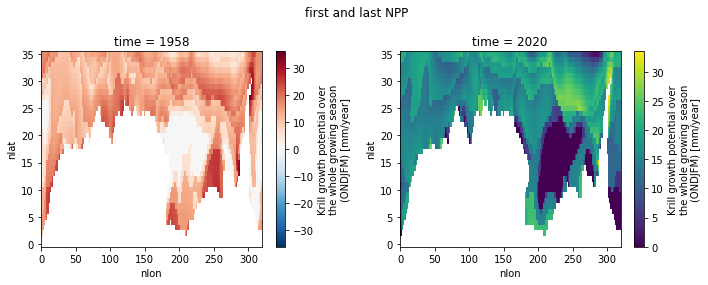

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [37]:
mem_5_ints = ds.KGP_ONDJFM

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_ints.isel(time=0).plot(ax=ax1)
# ax1.set_title(mem_5_ints.isel(time=0).time.values)

mem_5_ints.isel(time=-1).plot(ax=ax2)
#ax2.set_title(mem_5_ints.isel(time=-1).time.values)

fig.suptitle("first and last NPP")

plt.tight_layout()
plt.show()